# Semi-Analytic Matched Filter Mismatch Loss for Scipy 2020

In [1]:
%pylab inline
#%pylab notebook
#%matplotlib qt
import sk_dsp_comm.sigsys as ss
import sk_dsp_comm.digitalcom as dc
import scipy.signal as signal
from scipy.stats import norm
import scipy.optimize as optimize
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX

In [3]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context('notebook') # 'paper' 'talk' 'poster' 'notebook'

## The SRC Pulse Shape

In [4]:
p_25 = dc.sqrt_rc_imp(10,0.25,8)
p_50 = dc.sqrt_rc_imp(10,0.5,8)
n = arange(len(p_25)) - 8*10

(0, 4.2)

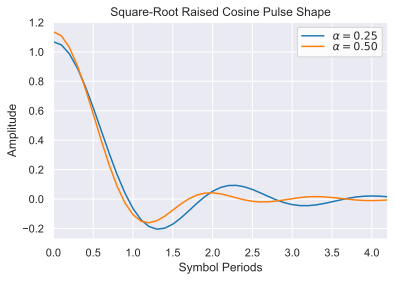

In [5]:
plot(n/10,p_25)
plot(n/10,p_50)
title(r'Square-Root Raised Cosine Pulse Shape')
ylabel(r'Amplitude')
xlabel(r'Symbol Periods')
legend((r'$\alpha=0.25$',r'$\alpha=0.50$'),
       facecolor='white',labelspacing=0.05);
xlim([0,4.2])

In [6]:
p_rc = signal.convolve(p_25,p_25)/10
p_rcmm = signal.convolve(p_25,p_50)/10
nn = arange(len(p_rc)) - 16*10

(0, 4.2)

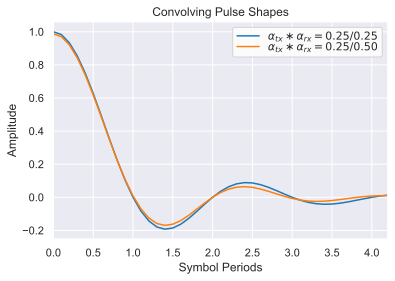

In [7]:
plot(nn/10,p_rc)
plot(nn/10,p_rcmm)
title(r'Convolving Pulse Shapes')
ylabel(r'Amplitude')
xlabel(r'Symbol Periods')
legend((r'$\alpha_{tx}\ast\alpha_{rx}=0.25/0.25$',r'$\alpha_{tx}\ast\alpha_{rx}=0.25/0.50$'),
       facecolor='white',labelspacing=0.05);
xlim([0,4.2])
# ylim([-.1,.1])

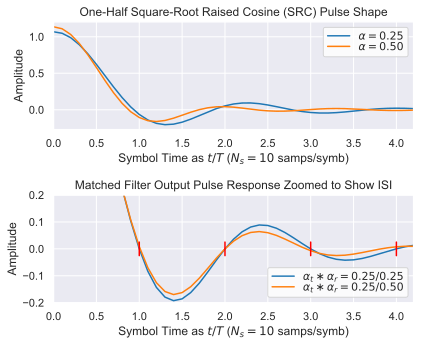

In [8]:
figure(figsize=(6,5))
subplot(211)
plot(n/10,p_25)
plot(n/10,p_50)
title(r'One-Half Square-Root Raised Cosine (SRC) Pulse Shape')
ylabel(r'Amplitude')
xlabel(r'Symbol Time as $t/T$ ($N_s=10$ samps/symb)')
legend((r'$\alpha=0.25$',r'$\alpha=0.50$'),
       facecolor='white',labelspacing=0.05);
xlim([0,4.2])

subplot(212)
plot(nn/10,p_rc)
plot(nn/10,p_rcmm)
plot([1,1],[-.025,.025],'r')
plot([2,2],[-.025,.025],'r')
plot([3,3],[-.025,.025],'r')
plot([4,4],[-.025,.025],'r')
title(r'Matched Filter Output Pulse Response Zoomed to Show ISI')
ylabel(r'Amplitude')
xlabel(r'Symbol Time as $t/T$ ($N_s=10$ samps/symb)')
legend((r'$\alpha_t\ast\alpha_r =0.25/0.25$',r'$\alpha_{t}\ast\alpha_{r}=0.25/0.50$'),
       facecolor='white',labelspacing=0.05);
xlim([0,4.2])
ylim([-.2,.2])

tight_layout()
savefig('SRC_plots.pdf')

## Semianalytic SEP and BEP for MPSK and QAM
Since the tx to rx path is linear, it is possible to use a *semianalytic* simulation approach in the degradation analysis.

In [ ]:
subplot(221)
M = 4
Filter_span = 6
sa_QAM_basic = QAM_sa_BEP(M,0.5,0.5,N_symb=2000,M_span=Filter_span)
plot(sa_QAM_basic.z.real,sa_QAM_basic.z.imag,'.')
axis('equal');
title(r'$T_{pulse}=\pm 6T$ and $\alpha_{t/r} = 0.5$')
ylabel(r'Quadrature')
xlabel(r'Inphase')
subplot(222)
M = 4
Filter_span = 8
sa_QAM_basic = QAM_sa_BEP(M,0.5,0.5,N_symb=2000,M_span=Filter_span)
plot(sa_QAM_basic.z.real,sa_QAM_basic.z.imag,'.')
axis('equal');
title(r'$T_{pulse}=\pm 8T$ and $\alpha_{t/r} = 0.5$')
ylabel(r'Quadrature')
xlabel(r'Inphase')
subplot(223)
M = 4
Filter_span = 6
sa_QAM_basic = QAM_sa_BEP(M,0.25,0.25,N_symb=2000,M_span=Filter_span)
plot(sa_QAM_basic.z.real,sa_QAM_basic.z.imag,'.')
axis('equal');
title(r'$T_{pulse}=\pm 6T$ and $\alpha_{t/r} = 0.25$')
ylabel(r'Quadrature')
xlabel(r'Inphase')
subplot(224)
M = 4
Filter_span = 8
sa_QAM_basic = QAM_sa_BEP(M,0.25,0.25,N_symb=2000,M_span=Filter_span)
plot(sa_QAM_basic.z.real,sa_QAM_basic.z.imag,'.')
axis('equal');
title(r'$T_{pulse}=\pm 8T$ and $\alpha_{t/r} = 0.25$')
ylabel(r'Quadrature')
xlabel(r'Inphase')
tight_layout()
savefig('SRC_residuals.pdf')

### Semianalytic MPSK BEP $P_e$ Approximation

In [12]:
import scipy.integrate as integrate

In [13]:
def MPSK_exact_integrand(phi,M,EbN0_dB):
    """
    
    Mark Wickert October 2019
    """
    EsN0 = 10**(EbN0_dB/10) * log2(M)
    I1 = exp(- EsN0*sin(pi/M)**2/sin(phi)**2)/pi
    return I1

In [14]:
EbN0_dB = 10.5
M = 4
def BEP_thy_exact(EbN0_dB, M):
    """
    
    Mark Wickert October 2019
    """
    P_b_exact = integrate.quad(MPSK_exact_integrand,0,pi - pi/M,args=(M,EbN0_dB))/log2(M)
    return P_b_exact[0]

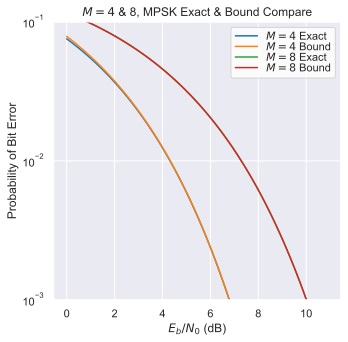

In [15]:
EbN0 = arange(0,11,0.1)
M = [4,8]
BEP_exact = zeros((len(EbN0),2))
for m in range(2):
    for k, EbN0_k in enumerate(EbN0):
        BEP_exact[k,m] = BEP_thy_exact(EbN0_k, M[m])
BEP_thy4 = dc.MPSK_BEP_thy(EbN0,4)
BEP_thy8 = dc.MPSK_BEP_thy(EbN0,8)
figure(figsize=(5,5))
semilogy(EbN0,BEP_exact[:,0])
semilogy(EbN0,BEP_thy4)
semilogy(EbN0,BEP_exact[:,1])
semilogy(EbN0,BEP_thy8)
ylim([1e-3,1e-1])
title(r'$M=4$ & 8, MPSK Exact & Bound Compare')
xlabel(r'$E_b/N_0$ (dB)')
ylabel(r'Probability of Bit Error')
legend((r'$M=4$ Exact',r'$M=4$ Bound',
        r'$M=8$ Exact',r'$M=8$ Bound'),
       facecolor='white',labelspacing=0.05);
#grid();
tight_layout()
savefig('BEP_4PSK_8PSK_exact_bound_plt.pdf')

### Semianalytic MPSK BEP: The Class `MPSK_sa_BEP`
This class does all of the *heavy lifting* for the pulse mismatch analysis involving MPSK modulation.

In [4]:
# EbN0 = array([10.5])
EbN0 = arange(4,15,.1)
# EbN0 = arange(10,20,.1)
# EbN0 = arange(20,30,.1)

M = 8
N_bits = 1000
Ns = 10
alpha_tx = 0.35
alpha_rx = 0.35
# Find ideal reference signal points using rect pulse and rect MF
x_ref,b_tr,data = dc.MPSK_gray_encode_bb(1000,Ns,M,'rect',alpha_tx)
z_ref = signal.lfilter(b_tr,1,x_ref)
xI_ref, xQ_ref = dc.scatter(z_ref,Ns,Ns-1)
# Form transmitted QAM with desired tx pulse shaping
x_MFMM,b_t,data = dc.MPSK_gray_encode_bb(None,Ns,M,'src',alpha_tx,data)
# Matched filter, with mismatch    
b_r = dc.sqrt_rc_imp(10,alpha_rx)/Ns
z_MFMM = signal.lfilter(b_r,1,x_MFMM)
xI, xQ = dc.scatter(z_MFMM,Ns,0+Ns*12) # Lag due to tx+rx filter delay
# Decison variable with ISI centered on (1,0)
z = 1 + xI-xI_ref[:-12] + 1j*(xQ-xQ_ref[:-12])
# Semianalytic variables
# To provide a range of Eb/N0 value we change sig_w
Es = Ns*np.var(x_MFMM)
EsN0 = EbN0 + 10*log10(log2(M))
N0_IQ = Es*10**(-EsN0/10.)/2.
sig_w = sqrt(N0_IQ*sum(b_r**2))

N_tot = len(z)
BEP_hat = 0
for k in range(N_tot):
    if M == 2:
        BEP_hat += norm.sf(real(z[k])/sig_w)
    
    else:
        BEP_hat += (norm.sf(abs(z[k])*sin(pi/M-angle(z[k]))/sig_w) + \
                   norm.sf(abs(z[k])*sin(pi/M+angle(z[k]))/sig_w))/log2(M)
# Average Pe over cases and ISI patterns        
BEP_hat /= N_tot
#BEP_hat

In [9]:
class MPSK_sa_BEP(object):
    """
    A class for semianalytic BEP analysis of pulse shape mismatch in a MPSK data link
    
    Mark Wickert October 2019
    """
    
    
    def __init__(self,M,alpha_tx,alpha_rx, N_symb = 1000,Ns = 10,M_span = 6,ext_data = None):
        """
        Initialize the object
        
        """
        self.M = M
        self.alpha_tx = alpha_tx
        self.alpha_rx = alpha_rx
        self.N_symb = N_symb
        self.Ns = Ns
        self.M_span = M_span
        
        # Find ideal reference signal points using rect pulse and rect MF
        if N_symb == None:
            x_ref,b_tr,data = dc.MPSK_gray_encode_bb(None,self.Ns,M,'rect',self.alpha_tx,ext_data=ext_data)
        else:
            x_ref,b_tr,data = dc.MPSK_gray_encode_bb(N_symb,self.Ns,M,'rect',self.alpha_tx)
        self.data = data
        z_ref = signal.lfilter(b_tr,1,x_ref)
        xI_ref, xQ_ref = dc.scatter(z_ref,Ns,Ns-1)
        self.xI_ref = xI_ref
        self.xQ_ref = xQ_ref
        # Form transmitted QAM with desired tx pulse shaping
        x_txps,b_t,data = dc.MPSK_gray_encode_bb(None,self.Ns,self.M,'src',self.alpha_tx,M_span,ext_data=data)
        self.x_txps = x_txps
        self.b_t = b_t
        # Matched filter, with mismatch    
        self.b_r = dc.sqrt_rc_imp(self.Ns,alpha_rx,self.M_span)/self.Ns
        z_MFMM = signal.lfilter(self.b_r,1,x_txps)
        self.z_MFMM = z_MFMM
        # Noise free MF output
        xI, xQ = dc.scatter(z_MFMM,self.Ns,0+Ns*(self.M_span+self.M_span)) # Lag due to tx+rx filter delay
        self.xI = xI
        self.xQ = xQ
        # Decison variable with ISI centered on (1,0)
        self.z = 1 + xI-xI_ref[:-self.M_span-self.M_span] + 1j*(xQ-xQ_ref[:-self.M_span-self.M_span])
        # Received energy per symbol
        self.Es = self.Ns*np.var(x_txps)    
    
    
    def sa_BEP(self,EbN0_dB):
        """
        Calculate the semianalytic BEP over a range of Eb/N0 values in dB
        
        """
        # Semianalytic variables
        # To provide a range of Eb/N0 value we change sig_w
        EsN0_dB = EbN0_dB + 10*log10(log2(self.M))
        N0_IQ = self.Es*10**(-EsN0_dB/10.)/2.
        sig_w = sqrt(N0_IQ*sum(np.abs(self.b_r)**2))
        N_tot = len(self.z)
        BEP_hat = 0 # np.zeros(len(sig_w))
        for k in range(N_tot):
            if self.M == 2:
                BEP_hat += norm.sf(real(self.z[k])/sig_w)

            else:
                BEP_hat += (norm.sf(abs(self.z[k])*sin(pi/self.M-angle(self.z[k]))/sig_w) + \
                           norm.sf(abs(self.z[k])*sin(pi/self.M+angle(self.z[k]))/sig_w))/log2(self.M)
        # Average Pe over cases and ISI patterns        
        BEP_hat /= N_tot
        return BEP_hat
    
    
    def sa_eq_BEP(self,EbN0_dB):
        """
        Calculate the semianalytic BEP with EQ over a range of Eb/N0 values in dB
        
        """
        # Semianalytic variables
        # To provide a range of Eb/N0 value we change sig_w
        EsN0_dB = EbN0_dB + 10*log10(log2(self.M))
        N0_IQ = self.Es*10**(-EsN0_dB/10.)/2.
        sig_w = sqrt(N0_IQ*sum(np.abs(self.b_r_eq)**2))
        N_tot = len(self.z_eq_nn)
        BEP_hat = 0 # np.zeros(len(sig_w))
        for k in range(N_tot):
            if self.M == 2:
                BEP_hat += norm.sf(real(self.z_eq_nn[k])/sig_w)

            else:
                BEP_hat += (norm.sf(abs(self.z_eq_nn[k])*sin(pi/self.M-angle(self.z_eq_nn[k]))/sig_w) + \
                           norm.sf(abs(self.z_eq_nn[k])*sin(pi/self.M+angle(self.z_eq_nn[k]))/sig_w))/log2(self.M)
        # Average Pe over cases and ISI patterns        
        BEP_hat /= N_tot
        return BEP_hat
    
    
    def degradation(self,BEP_thresh, EQ = False, search_int = [0, 25]):
        """
        BEP degradion in dB at threshold
        """
        thresh_cross_dB = optimize.brentq(self.BEP_zero_actual,
                                          search_int[0],search_int[1],
                                          args=(BEP_thresh, EQ))
        thresh_cross_ideal_dB = optimize.brentq(self.BEP_zero_ideal,
                                                search_int[0],search_int[1],
                                                args=(BEP_thresh,))
        print('BEP Threshold crossings: MF mismatch {:6.3f} dB, Ideal {:6.3f} dB'\
              .format(thresh_cross_dB, thresh_cross_ideal_dB))
        return thresh_cross_dB - thresh_cross_ideal_dB
    
    
    def deg_polyfit(self,BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9], EQ = False, search_int = [0, 25],display=False):
        """
        BEP degradion in dB at threshold values using polyfit for interpolation
        """
        EbN0 = arange(search_int[0],search_int[1],.1)
        BEP_hat = self.sa_BEP(EbN0)
        BEP_thy = dc.MPSK_BEP_thy(EbN0,M,True)
        degradation_dB = zeros(len(BEP_thres))
        for n_BEP_t, BEP_t in enumerate(BEP_thres):
            # Find Mismatch EbNo crossing (with mismatch)
            idx_above = nonzero(ravel(BEP_hat > BEP_t))[0]
            if len(idx_above) < 2:
                raise Exception('Decrease lower end of EbN0 range below {:1.2f}'.format(EbN0[0]))
            idx_below = nonzero(ravel(BEP_hat < BEP_t))[0]
            if len(idx_below) < 2:
                raise Exception('Increase upper end of EbN0 range above {:1.2f}'.format(EbN0[-1]))
            p3 =  polyfit(log10(BEP_hat[hstack((idx_above[-2:],idx_below[0:2]))]),
                          EbN0[hstack((idx_above[-2:],idx_below[0:2]))],3)
            EbN0_mis = polyval(p3,log10(BEP_t))
            # Find Theory EbNo crossing (ideal)
            idx_above = nonzero(ravel(BEP_thy > BEP_t))[0]
            idx_below = nonzero(ravel(BEP_thy < BEP_t))[0]
            p3_thy =  polyfit(log10(BEP_thy[hstack((idx_above[-2:],idx_below[0:2]))]),
                          EbN0[hstack((idx_above[-2:],idx_below[0:2] ))],3)
            EbN0_thy = polyval(p3_thy,log10(BEP_t))
            if display:
                print('BEP_threshold = {:1.2e}, Degradation = {:1.4f} dB'.format(BEP_t,EbN0_mis - EbN0_thy)) 
            degradation_dB[n_BEP_t] = EbN0_mis - EbN0_thy
        return degradation_dB
            

    def BEP_zero_actual(self, snr_dB, BEP_thresh, EQ):
        """
        Helper function for brentq zero crossing (fixed point) actual BEP
        """
        if EQ == False:
            BEP = self.sa_BEP(snr_dB) - BEP_thresh
        else:
            BEP = self.sa_eq_BEP(snr_dB) - BEP_thresh
        return BEP


    def BEP_zero_ideal(self, snr_dB, BEP_thresh):
        """
        Helper function for brentq zero crossing (fixed point) ideal BEP
        """
        BEP = dc.MPSK_BEP_thy(snr_dB, self.M) - BEP_thresh
        return BEP
    
    
    def MMSE_DFE(self,N_taps,EbN0_dB,mu = 0.005):
        """
        MMSE Descision feedback equalizer with AWGN present to allow the 
        equalizer FIR filter to be designed using a signal with ISI and noise
        present.
        """
        self.N_EQ = N_taps
        N_taps_half = (N_taps-1)//2
        N_sim = len(self.xI)
        r_noise = dc.cpx_AWGN(self.x_txps, EbN0_dB + 10*log10(log2(self.M)), self.Ns)
        z_MFMM = signal.lfilter(self.b_r,1,r_noise)
        xI, xQ = dc.scatter(z_MFMM,self.Ns,0+self.Ns*(self.M_span+self.M_span)) # Lag due to tx+rx filter delay
        r = xI + 1j*xQ

        self.z_eq = zeros(N_sim,dtype=complex128)
        self.e_eq = zeros(N_sim,dtype=complex128)
        self.Aopt_eq = hstack((zeros(N_taps_half), [1], zeros(N_taps_half)))
        y_states = zeros(N_taps,dtype=complex128)
        h_delay_filt = hstack((zeros(N_taps_half),[1]))
        d_hat_del = signal.lfilter(h_delay_filt,1,self.xI_ref + 1j*self.xQ_ref)

        # Begin the LMS simulation sample-by-sample outer loop
        for k in range(N_sim):
            # Update input state vector
            y_states = hstack(([r[k]], y_states[:-1]))

            # Apply Filter
            self.z_eq[k] = dot(self.Aopt_eq,y_states)

            # Form the DFE error sequence using hard decision reference symbols with delay
            self.e_eq[k] = d_hat_del[k] - self.z_eq[k]

            # Update the filter coefficients (LMS update eqn)
            self.Aopt_eq = self.Aopt_eq + mu*conj(y_states)*self.e_eq[k]
        # Filter the MF output samples with the equalizer (no noise)
        xIQ_eq_nn = signal.lfilter(self.Aopt_eq,1,self.xI + 1j*self.xQ)
        # Trim to account for added delay of N_taps_half
        xIQ_eq_nn = xIQ_eq_nn[N_taps_half:]
        self.xI_eq_nn = real(xIQ_eq_nn)
        self.xQ_eq_nn = imag(xIQ_eq_nn)
        # Create composite receive filter
        self.b_r_eq = signal.convolve(self.b_r,dc.upsample(self.Aopt_eq,self.Ns))
        # Decison variable with ISI centered on (1,0)
        self.z_eq_nn = 1 + self.xI_eq_nn-self.xI_ref[:-self.M_span-self.M_span-N_taps_half] \
                         + 1j*(self.xQ_eq_nn-self.xQ_ref[:-self.M_span-self.M_span-N_taps_half])

### MPSK Case Studies

#### A Quick Degradation Analysis

In [11]:
M = 32
M_span = 8
alpha_tx = 0.35
alpha_rx = 0.25
# Consistently test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,30]);
for k, deg_dBk in enumerate(deg_dB):
    print('At BEP Thresh = {:1.0e} the degradation is {:2.2f} dB'\
          .format(BEP_thres[k],deg_dBk))

At BEP Thresh = 1e-05 the degradation is 0.15 dB
At BEP Thresh = 1e-06 the degradation is 0.19 dB
At BEP Thresh = 1e-07 the degradation is 0.23 dB
At BEP Thresh = 1e-08 the degradation is 0.27 dB
At BEP Thresh = 1e-09 the degradation is 0.31 dB


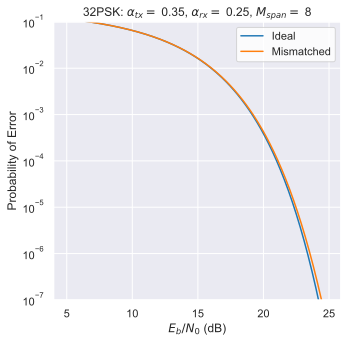

In [12]:
EbN0 = arange(5,25,.1)
BEP_hat = sa_MPSK_basic.sa_BEP(EbN0)
BEP_thy = dc.MPSK_BEP_thy(EbN0,M,True)
figure(figsize=(5,5))
semilogy(EbN0,BEP_thy,label=r'Ideal')
semilogy(EbN0,BEP_hat,label=r'Mismatched')
ylim([1e-7,1e-1])
title(r'%dPSK: $\alpha_{tx} =$ %1.2f, $\alpha_{rx} =$ %1.2f, $M_{span} =$ %d' \
      % (M,alpha_tx,alpha_rx, M_span))
xlabel(r'$E_b/N_0$ (dB)')
ylabel(r'Probability of Error')
# legend = legend((r'Ideal',r'Mismatched'))
legend_obj = legend()
frame = legend_obj.get_frame()
frame.set_facecolor('white')
#grid();
tight_layout()
# savefig('BEP_16QAM_25to25_5d_plt.pdf')

In [13]:
M = 32
M_span = 8
alpha_tx = 0.35
alpha_rx = 0.35
# Consistently test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(3,30,.1) # arange(3,18,.01)
# BEP_hat_ref1 = sa_MPSK_basic_ref1.sa_BEP(EbN0)
# BEP_hat_ref2 = sa_MPSK_basic_ref2.sa_BEP(EbN0)
BEP_hat = sa_MPSK_basic.sa_BEP(EbN0)
BEP_thy = dc.MPSK_BEP_thy(EbN0,M,True)
for BEP_t in BEP_thres:
    # Find Mismatch EbNo crossing (with mismatch)
    idx_above = nonzero(ravel(BEP_hat > BEP_t))[0]
    if len(idx_above) < 2:
        raise Exception('Decrease lower end of EbN0 range below {:1.2f}'.format(EbN0[0]))
    idx_below = nonzero(ravel(BEP_hat < BEP_t))[0]
    if len(idx_below) < 2:
        raise Exception('Increase upper end of EbN0 range above {:1.2f}'.format(EbN0[-1]))
    p3 =  polyfit(log10(BEP_hat[hstack((idx_above[-2:],idx_below[0:2]))]),
                  EbN0[hstack((idx_above[-2:],idx_below[0:2]))],3)
    EbN0_mis = polyval(p3,log10(BEP_t))
    # Find Theory EbNo crossing (ideal)
    idx_above = nonzero(ravel(BEP_thy > BEP_t))[0]
    idx_below = nonzero(ravel(BEP_thy < BEP_t))[0]
    p3_thy =  polyfit(log10(BEP_thy[hstack((idx_above[-2:],idx_below[0:2]))]),
                  EbN0[hstack((idx_above[-2:],idx_below[0:2] ))],3)
    EbN0_thy = polyval(p3_thy,log10(BEP_t))
    print('BEP_threshold = {:1.2e}, Degradation = {:1.4f} dB'.format(BEP_t,EbN0_mis - EbN0_thy))
#     print(EbN0_thy,EbN0_mis)

BEP_threshold = 1.00e-05, Degradation = 0.0297 dB
BEP_threshold = 1.00e-06, Degradation = 0.0381 dB
BEP_threshold = 1.00e-07, Degradation = 0.0464 dB
BEP_threshold = 1.00e-08, Degradation = 0.0548 dB
BEP_threshold = 1.00e-09, Degradation = 0.0630 dB


#### MPSK Basics

In [284]:
M = 8
Filter_span = 6
sa_MPSK_basic = MPSK_sa_BEP(M,0.25,0.25,N_symb=5000,M_span=Filter_span)

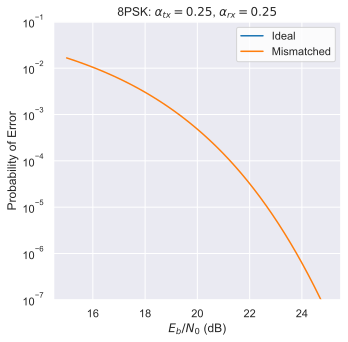

In [285]:
EbN0 = arange(15,25,.01)
BEP_hat = sa_MPSK.sa_BEP(EbN0)
# BEP_hat = sa_MPSK.sa_eq_BEP(EbN0)
BEP_thy = dc.MPSK_BEP_thy(EbN0,M,True)
figure(figsize=(5,5))
semilogy(EbN0,BEP_thy,label=r'Ideal')
semilogy(EbN0,BEP_hat,label=r'Mismatched')
ylim([1e-7,1e-1])
title(r'8PSK: $\alpha_{tx} = 0.25$, $\alpha_{rx} = 0.25$')
xlabel(r'$E_b/N_0$ (dB)')
ylabel(r'Probability of Error')
# legend = legend((r'Ideal',r'Mismatched'))
legend_obj = legend()
frame = legend_obj.get_frame()
frame.set_facecolor('white')
#grid();
tight_layout()
savefig('BEP_8PSK_25to25_5d_plt.pdf')

#### Without Equalization

In [280]:
M = 32
sa_MPSK = MPSK_sa_BEP(M,0.25,0.35,N_symb=5000,M_span=6)

In [281]:
BEP_thesh = 1e-6
D_dB = sa_MPSK.degradation(BEP_thesh,False,[9,25])
print('Degradation at {} is {:6.3f} dB'.format(BEP_thesh,D_dB))

BEP Threshold crossings: MF mismatch 23.797 dB, Ideal 23.362 dB
Degradation at 1e-06 is  0.435 dB


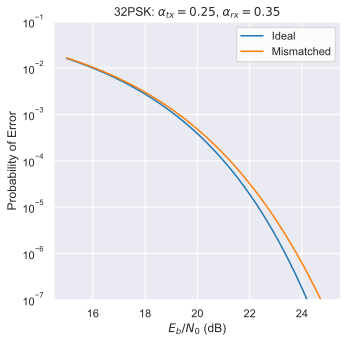

In [283]:
EbN0 = arange(15,25,.01)
BEP_hat = sa_MPSK.sa_BEP(EbN0)
# BEP_hat = sa_MPSK.sa_eq_BEP(EbN0)
BEP_thy = dc.MPSK_BEP_thy(EbN0,M,True)
figure(figsize=(5,5))
semilogy(EbN0,BEP_thy,label=r'Ideal')
semilogy(EbN0,BEP_hat,label=r'Mismatched')
ylim([1e-7,1e-1])
title(r'32PSK: $\alpha_{tx} = 0.25$, $\alpha_{rx} = 0.35$')
xlabel(r'$E_b/N_0$ (dB)')
ylabel(r'Probability of Error')
# legend = legend((r'Ideal',r'Mismatched'))
legend_obj = legend()
frame = legend_obj.get_frame()
frame.set_facecolor('white')
#grid();
tight_layout()
savefig('BEP_32PSK_25to35_noeq.pdf')

In [268]:
M = 32
sa_MPSK = MPSK_sa_BEP(M,0.35,0.25,N_symb=5000,M_span=6)

In [270]:
BEP_thesh = 1e-6
D_dB = sa_MPSK.degradation(BEP_thesh,False,[9,25])
print('Degradation at {} is {:6.3f} dB'.format(BEP_thesh,D_dB))

BEP Threshold crossings: MF mismatch 23.808 dB, Ideal 23.362 dB
Degradation at 1e-06 is  0.445 dB


In [22]:
fig.write_image('BEP_32PSK_25to35.pdf')

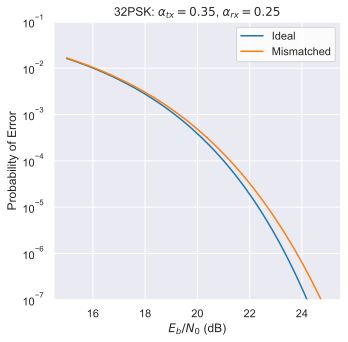

In [272]:
EbN0 = arange(15,25,.01)
BEP_hat = sa_MPSK.sa_BEP(EbN0)
# BEP_hat = sa_MPSK.sa_eq_BEP(EbN0)
BEP_thy = dc.MPSK_BEP_thy(EbN0,M,True)
figure(figsize=(5,5))
semilogy(EbN0,BEP_thy,label=r'Ideal')
semilogy(EbN0,BEP_hat,label=r'Mismatched')
ylim([1e-7,1e-1])
title(r'32PSK: $\alpha_{tx} = 0.35$, $\alpha_{rx} = 0.25$')
xlabel(r'$E_b/N_0$ (dB)')
ylabel(r'Probability of Error')
# legend = legend((r'Ideal',r'Mismatched'))
legend_obj = legend()
frame = legend_obj.get_frame()
frame.set_facecolor('white')
#grid();
tight_layout()
#savefig('BEP_32PSK_25to35_5d_plt.pdf')

#### With Equalization

In [139]:
M = 16
sa_MPSK = MPSK_sa_BEP(M,0.25,0.5,N_symb=2000,M_span=6)

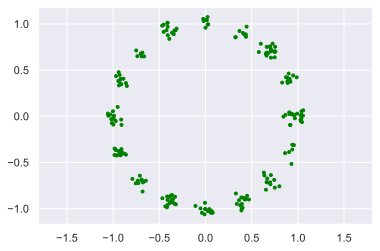

In [140]:
EbNo_operate = 18
N_taps = 11
sa_MPSK.MMSE_DFE(N_taps,EbNo_operate,mu=0.005)

plot(real(sa_MPSK.z_eq[-200:]),imag(sa_MPSK.z_eq[-200:]),'g.')
axis('equal');
# dc.eye_plot(real(z_eq),2,700)
# dc.eye_plot(sa_MPSK.xI,2,10*(6+6))
#grid()

In [ ]:
# stem(abs(sa_MPSK.Aopt_eq),use_line_collection=True)
fig = pltly.plotly_stem(arange(0,11),real(sa_MPSK.Aopt_eq),
                        r'Index n',r'Re()',r'Equalizer Real Part',
                        stem_width=0.5, width=650);
np.sum(abs(sa_MPSK.Aopt_eq))
# 10*log10(sum(abs(sa_MPSK.Aopt_eq)**2))

Text(0.5, 0, 'Symbol Index')

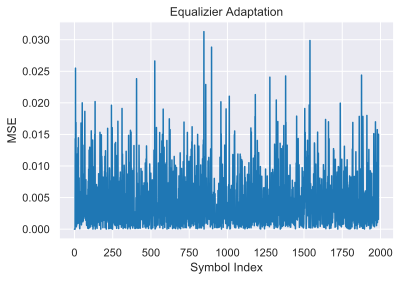

In [142]:
plot(abs(sa_MPSK.e_eq)**2)
title(r'Equalizier Adaptation')
ylabel(r'MSE')
xlabel(r'Symbol Index')

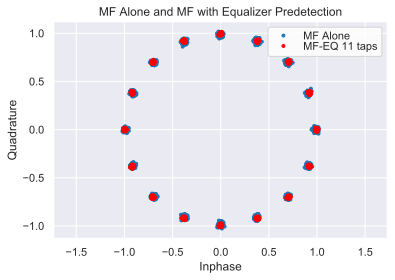

In [143]:
plot(sa_MPSK.xI,sa_MPSK.xQ,'.')
plot(sa_MPSK.xI_eq_nn,sa_MPSK.xQ_eq_nn,'r.')
axis('equal');
title(r'MF Alone and MF with Equalizer Predetection')
ylabel(r'Quadrature')
xlabel(r'Inphase')
legend((r'MF Alone',r'MF-EQ {} taps'.format(11)),
       facecolor='white',labelspacing=0.02);

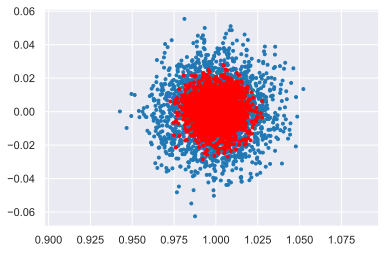

In [144]:
plot(sa_MPSK.z.real,sa_MPSK.z.imag,'.')
plot(sa_MPSK.z_eq_nn.real,sa_MPSK.z_eq_nn.imag,'r.')
axis('equal');
# title(r'MF Alone and MF with Equalizer Predetection')
# ylabel(r'Quadrature')
# xlabel(r'Inphase')
# legend((r'MF Alone',r'MF-EQ {} taps'.format(11)),
#        facecolor='white',labelspacing=0.02);

In [145]:
BEP_thesh = 1e-6
D_dB = sa_MPSK.degradation(BEP_thesh,False,[9,25])
print('Degradation at {} is {:6.3f} dB'.format(BEP_thesh,D_dB))

BEP Threshold crossings: MF mismatch 19.202 dB, Ideal 18.441 dB
Degradation at 1e-06 is  0.761 dB


In [ ]:
EbN0 = arange(5,20,.01)
BEP_hat = sa_MPSK.sa_BEP(EbN0)
# BEP_hat = sa_MPSK.sa_eq_BEP(EbN0)
BEP_thy = dc.MPSK_BEP_thy(EbN0,M,True)
# pltly.BEP_plot(EbN0,BEP_thy,BEP_hat, r'32-PSK: alpha_tx = 0.25, alpha_rx = 0.35');
pltly.BEP_plot(EbN0,BEP_thy,BEP_hat, r'$\text{32-PSK: }\alpha_{tx} = 0.25, \alpha_{rx} = 0.35$');

In [22]:
fig.write_image('BEP_32PSK_25to35.pdf')

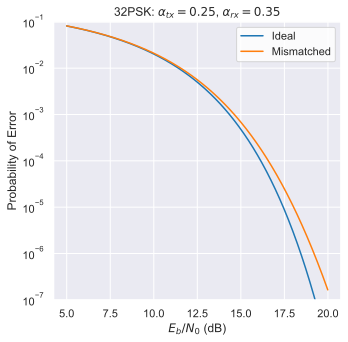

In [149]:
figure(figsize=(5,5))
semilogy(EbN0,BEP_thy,label=r'Ideal')
semilogy(EbN0,BEP_hat,label=r'Mismatched')
ylim([1e-7,1e-1])
title(r'32PSK: $\alpha_{tx} = 0.25$, $\alpha_{rx} = 0.35$')
xlabel(r'$E_b/N_0$ (dB)')
ylabel(r'Probability of Error')
# legend = legend((r'Ideal',r'Mismatched'))
legend_obj = legend()
frame = legend_obj.get_frame()
frame.set_facecolor('white')
#grid();
tight_layout()
savefig('BEP_32PSK_25to35_5d_plt.pdf')

### Semianalytic QAM BEP: The Class `QAM_sa_BEP`
This class does all of the *heavy lifting* for the pulse mismatch analysis involving MQAM modulation.

In [70]:
# EbN0 = arange(4,15,.1)
# EbN0 = arange(10,20,.1)
EbN0 = arange(15,25,.1)
M = 256
N_bits = 1000
Ns = 10
alpha_tx = 0.35
alpha_rx = 0.35
M_span = 8
# Find ideal reference signal points using rect pulse and rect MF
x_ref,b_tr,data = dc.QAM_gray_encode_bb(N_bits,Ns,M,'rect',alpha_tx)
z_ref = signal.lfilter(b_tr,1,x_ref)
xI_ref, xQ_ref = dc.scatter(z_ref,Ns,Ns-1)
# Form transmitted QAM with desired tx pulse shaping
x_MFMM,b_t,data = dc.QAM_gray_encode_bb(None,Ns,M,'src',alpha_tx,data)
# Matched filter, with mismatch    
b_r = dc.sqrt_rc_imp(10,alpha_rx,M_span)/Ns
z_MFMM = signal.lfilter(b_r,1,x_MFMM)
xI, xQ = dc.scatter(z_MFMM,Ns,0+Ns*(6+M_span)) # Lag due to tx+rx filter delay
# Decison variable with ISI centered on (0,0)
z = xI-xI_ref[:-6-M_span] + 1j*(xQ-xQ_ref[:-6-M_span])
# Semianalytic variables
# To provide a range of Eb/N0 value we change sig_w
Es = Ns*np.var(x_MFMM)
EsN0 = EbN0 + 10*log10(log2(M))
N0_IQ = Es*10**(-EsN0/10.)/2.
sig_w = sqrt(N0_IQ*sum(b_r**2))

# Decision squares are 2a x 2a, so
a = 1/(sqrt(M)-1)

N_tot = len(z)
BEP_hat = 0
for k in range(N_tot):
    # Test for Type III and compute conditional Pe
    if (abs(xI_ref[k]) == 1) and (abs(xQ_ref[k]) == 1):
        BEP_hat += (norm.sf((a + real(z[k]))/sig_w) \
                  + norm.sf((a + imag(z[k]))/sig_w))/log2(M)
    # Test for Type II and compute conditional Pe
    elif ((abs(xI_ref[k]) == 1) and (abs(xQ_ref[k]) != 1)) or \
         ((abs(xI_ref[k]) != 1) and (abs(xQ_ref[k]) == 1)):
        BEP_hat += (norm.sf((a - real(z[k]))/sig_w) \
                  + norm.sf((a + real(z[k]))/sig_w) \
                  + norm.sf((a + imag(z[k]))/sig_w))/log2(M)
    # Else case is Type I and compute conditional Pe
    else:
        BEP_hat += (norm.sf((a + real(z[k]))/sig_w) \
                  + norm.sf((a - real(z[k]))/sig_w) \
                  + norm.sf((a + imag(z[k]))/sig_w) \
                  + norm.sf((a - imag(z[k]))/sig_w))/log2(M)
# Average Pe over cases and ISI patterns        
BEP_hat /= N_tot
# BEP_hat

In [10]:
class QAM_sa_BEP(object):
    """
    A class for semianalytic BEP analysis of pulse shape mismatch in a QAM data link
    
    Mark Wickert October 2019
    """
    
    
    def __init__(self,M,alpha_tx,alpha_rx, N_symb = 1000,Ns = 10,M_span = 6,ext_data = None):
        """
        Initialize the object
        
        """
        self.M = M
        self.alpha_tx = alpha_tx
        self.alpha_rx = alpha_rx
        self.N_symb = N_symb
        self.Ns = Ns
        self.M_span = M_span
        
        # Find ideal reference signal points using rect pulse and rect MF
        if N_symb == None:
            x_ref,b_tr,data = dc.QAM_gray_encode_bb(None,self.Ns,self.M,'rect',self.alpha_tx,ext_data)
        else:
            x_ref,b_tr,data = dc.QAM_gray_encode_bb(N_symb,self.Ns,self.M,'rect',self.alpha_tx)
        self.data = data
        z_ref = signal.lfilter(b_tr,1,x_ref)
        xI_ref, xQ_ref = dc.scatter(z_ref,Ns,Ns-1)
        self.xI_ref = xI_ref
        self.xQ_ref = xQ_ref
        # Form transmitted QAM with desired tx pulse shaping
        x_txps,b_t,data = dc.QAM_gray_encode_bb(None,self.Ns,self.M,'src',self.alpha_tx,M_span,data)
        self.x_txps = x_txps
        self.b_t = b_t        
        # Matched filter, with mismatch    
        self.b_r = dc.sqrt_rc_imp(self.Ns,alpha_rx,self.M_span)/self.Ns
        z_MFMM = signal.lfilter(self.b_r,1,x_txps)
        self.z_MFMM = z_MFMM
        # Noise free MF output
        xI, xQ = dc.scatter(z_MFMM,self.Ns,0+Ns*(self.M_span+self.M_span)) # Lag due to tx+rx filter delay
        self.xI = xI
        self.xQ = xQ
        # Decison variable with ISI centered on (0,0)
        self.z = xI-xI_ref[:-self.M_span-self.M_span] + 1j*(xQ-xQ_ref[:-self.M_span-self.M_span])
        # Received energy per symbol
        self.Es = self.Ns*np.var(x_txps)
        # Decision squares are 2a x 2a, so
        self.a = 1/(sqrt(self.M)-1)        
    
    
    def sa_BEP(self,EbN0_dB):
        """
        Calculate the semianalytic BEP over a range of Eb/N0 values in dB
        
        """
        # Semianalytic variables
        # To provide a range of Eb/N0 value we change sig_w
        EsN0_dB = EbN0_dB + 10*log10(log2(self.M))
        N0_IQ = self.Es*10**(-EsN0_dB/10.)/2.
        sig_w = sqrt(N0_IQ*sum(self.b_r**2))
        N_tot = len(self.z)
        BEP_hat = 0 # np.zeros(len(sig_w))
        for k in range(N_tot):
            # Test for Type III and compute conditional Pe
            if (abs(self.xI_ref[k]) == 1) and (abs(self.xQ_ref[k]) == 1):
                BEP_hat += (norm.sf((self.a + real(self.z[k]))/sig_w) \
                          + norm.sf((self.a + imag(self.z[k]))/sig_w))/log2(self.M)
            # Test for Type II and compute conditional Pe
            elif ((abs(self.xI_ref[k]) == 1) and (abs(self.xQ_ref[k]) != 1)) or \
                 ((abs(self.xI_ref[k]) != 1) and (abs(self.xQ_ref[k]) == 1)):
                BEP_hat += (norm.sf((self.a - real(self.z[k]))/sig_w) \
                          + norm.sf((self.a + real(self.z[k]))/sig_w) \
                          + norm.sf((self.a + imag(self.z[k]))/sig_w))/log2(self.M)
            # Else case is Type I and compute conditional Pe
            else:
                BEP_hat += (norm.sf((self.a + real(self.z[k]))/sig_w) \
                          + norm.sf((self.a - real(self.z[k]))/sig_w) \
                          + norm.sf((self.a + imag(self.z[k]))/sig_w) \
                          + norm.sf((self.a - imag(self.z[k]))/sig_w))/log2(self.M)
        # Average Pe over cases and ISI patterns        
        BEP_hat /= N_tot
        return BEP_hat
    
    
    def sa_eq_BEP(self,EbN0_dB):
        """
        Calculate the semianalytic BEP with EQ over a range of Eb/N0 values in dB

        """
        # Semianalytic variables
        # To provide a range of Eb/N0 value we change sig_w
        EsN0_dB = EbN0_dB + 10*log10(log2(self.M))
        N0_IQ = self.Es*10**(-EsN0_dB/10.)/2.
        sig_w = sqrt(N0_IQ*sum(np.abs(self.b_r_eq)**2))
        N_tot = len(self.z_eq_nn)
        BEP_hat = 0 # np.zeros(len(sig_w))
        for k in range(N_tot):
            # Test for Type III and compute conditional Pe
            if (abs(self.xI_ref[k]) == 1) and (abs(self.xQ_ref[k]) == 1):
                BEP_hat += (norm.sf((self.a + real(self.z_eq_nn[k]))/sig_w) \
                          + norm.sf((self.a + imag(self.z_eq_nn[k]))/sig_w))/log2(self.M)
            # Test for Type II and compute conditional Pe
            elif ((abs(self.xI_ref[k]) == 1) and (abs(self.xQ_ref[k]) != 1)) or \
                 ((abs(self.xI_ref[k]) != 1) and (abs(self.xQ_ref[k]) == 1)):
                BEP_hat += (norm.sf((self.a - real(self.z_eq_nn[k]))/sig_w) \
                          + norm.sf((self.a + real(self.z_eq_nn[k]))/sig_w) \
                          + norm.sf((self.a + imag(self.z_eq_nn[k]))/sig_w))/log2(self.M)
            # Else case is Type I and compute conditional Pe
            else:
                BEP_hat += (norm.sf((self.a + real(self.z_eq_nn[k]))/sig_w) \
                          + norm.sf((self.a - real(self.z_eq_nn[k]))/sig_w) \
                          + norm.sf((self.a + imag(self.z_eq_nn[k]))/sig_w) \
                          + norm.sf((self.a - imag(self.z_eq_nn[k]))/sig_w))/log2(self.M)
        # Average Pe over cases and ISI patterns        
        BEP_hat /= N_tot
        return BEP_hat
    
    
    def degradation(self,BEP_thresh, EQ = False, search_int = [0, 25]):
        """
        BEP degradation in dB at threshold
        """
        thresh_cross_dB = optimize.brentq(self.BEP_zero_actual,
                                          search_int[0],search_int[1],
                                          args=(BEP_thresh, EQ))
        thresh_cross_ideal_dB = optimize.brentq(self.BEP_zero_ideal,
                                                search_int[0],search_int[1],
                                                args=(BEP_thresh,))
        print('BEP Threshold crossings: MF mismatch {:6.3f} dB, Ideal {:6.3f} dB'\
              .format(thresh_cross_dB, thresh_cross_ideal_dB))
        return thresh_cross_dB - thresh_cross_ideal_dB
            
        
    def deg_polyfit(self,BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9], EQ = False, search_int = [0, 25],display=False):
        """
        BEP degradion in dB at threshold values using polyfit for interpolation
        """
        EbN0 = arange(search_int[0],search_int[1],.1)
        BEP_hat = self.sa_BEP(EbN0)
        BEP_thy = dc.QAM_BEP_thy(EbN0,M,True)
        degradation_dB = zeros(len(BEP_thres))
        for n_BEP_t, BEP_t in enumerate(BEP_thres):
            # Find Mismatch EbNo crossing (with mismatch)
            idx_above = nonzero(ravel(BEP_hat > BEP_t))[0]
            if len(idx_above) < 2:
                raise Exception('Decrease lower end of EbN0 range below {:1.2f}'.format(EbN0[0]))
            idx_below = nonzero(ravel(BEP_hat < BEP_t))[0]
            if len(idx_below) < 2:
                raise Exception('Increase upper end of EbN0 range above {:1.2f}'.format(EbN0[-1]))
            p3 =  polyfit(log10(BEP_hat[hstack((idx_above[-2:],idx_below[0:2]))]),
                          EbN0[hstack((idx_above[-2:],idx_below[0:2]))],3)
            EbN0_mis = polyval(p3,log10(BEP_t))
            # Find Theory EbNo crossing (ideal)
            idx_above = nonzero(ravel(BEP_thy > BEP_t))[0]
            idx_below = nonzero(ravel(BEP_thy < BEP_t))[0]
            p3_thy =  polyfit(log10(BEP_thy[hstack((idx_above[-2:],idx_below[0:2]))]),
                          EbN0[hstack((idx_above[-2:],idx_below[0:2] ))],3)
            EbN0_thy = polyval(p3_thy,log10(BEP_t))
            if display:
                print('BEP_threshold = {:1.2e}, Degradation = {:1.4f} dB'.format(BEP_t,EbN0_mis - EbN0_thy)) 
            degradation_dB[n_BEP_t] = EbN0_mis - EbN0_thy
        return degradation_dB
    

    def BEP_zero_actual(self, snr_dB, BEP_thresh, EQ):
        """
        Helper function for brentq zero crossing (fixed point) actual BEP
        """
        if EQ == False:
            BEP = self.sa_BEP(snr_dB) - BEP_thresh
        else:
            BEP = self.sa_eq_BEP(snr_dB) - BEP_thresh
        return BEP


    def BEP_zero_ideal(self, snr_dB, BEP_thresh):
        """
        Helper function for brentq zero crossing (fixed point) ideal BEP
        """
        BEP = dc.QAM_BEP_thy(snr_dB, self.M) - BEP_thresh
        return BEP
    
    
    def MMSE_DFE(self,N_taps,EbN0_dB,mu = 0.005):
        """
        MMSE Descision feedback equalizer with AWGN present to allow the 
        equalizer FIR filter to be designed using a signal with ISI and noise
        present.
        """
        self.N_EQ = N_taps
        N_taps_half = (N_taps-1)//2
        N_sim = len(self.xI)
        r_noise = dc.cpx_AWGN(self.x_txps, EbN0_dB + 10*log10(log2(self.M)), self.Ns)
        z_MFMM = signal.lfilter(self.b_r,1,r_noise)
        xI, xQ = dc.scatter(z_MFMM,self.Ns,0+self.Ns*(self.M_span+self.M_span)) # Lag due to tx+rx filter delay
        r = xI + 1j*xQ

        self.z_eq = zeros(N_sim,dtype=complex128)
        self.e_eq = zeros(N_sim,dtype=complex128)
        self.Aopt_eq = hstack((zeros(N_taps_half), [1], zeros(N_taps_half)))
        y_states = zeros(N_taps,dtype=complex128)
        h_delay_filt = hstack((zeros(N_taps_half),[1]))
        d_hat_del = signal.lfilter(h_delay_filt,1,self.xI_ref + 1j*self.xQ_ref)

        # Begin the LMS simulation sample-by-sample outer loop
        for k in range(N_sim):
            # Update input state vector
            y_states = hstack(([r[k]], y_states[:-1]))

            # Apply Filter
            self.z_eq[k] = dot(self.Aopt_eq,y_states)

            # Form the DFE error sequence using hard decision reference symbols with delay
            self.e_eq[k] = d_hat_del[k] - self.z_eq[k]

            # Update the filter coefficients (LMS update eqn)
            self.Aopt_eq = self.Aopt_eq + mu*conj(y_states)*self.e_eq[k]
        # Filter the MF output samples with the equalizer (no noise)
        xIQ_eq_nn = signal.lfilter(self.Aopt_eq,1,self.xI + 1j*self.xQ)
        # Trim to account for added delay of N_taps_half
        xIQ_eq_nn = xIQ_eq_nn[N_taps_half:]
        self.xI_eq_nn = real(xIQ_eq_nn)
        self.xQ_eq_nn = imag(xIQ_eq_nn)
        # Create composite receive filter
        self.b_r_eq = signal.convolve(self.b_r,dc.upsample(self.Aopt_eq,self.Ns))
        # Decison variable with ISI centered on (0,0)
        self.z_eq_nn = self.xI_eq_nn-self.xI_ref[:-self.M_span-self.M_span-N_taps_half] \
                       + 1j*(self.xQ_eq_nn-self.xQ_ref[:-self.M_span-self.M_span-N_taps_half])

### QAM Case Studies

#### QAM Basics

In [14]:
ext_data = int64(dc.m_seq(16))

In [15]:
M = 4
M_span = 8
alpha_tx = 0.5
alpha_rx = 0.5
# sa_QAM_basic_ref1 = QAM_sa_BEP(M,alpha_rx,alpha_rx,N_symb=None,M_span=M_span,ext_data=ext_data)
# sa_QAM_basic_ref2 = QAM_sa_BEP(M,alpha_tx,alpha_tx,N_symb=None,M_span=M_span,ext_data=ext_data)
# sa_QAM_basic_ref = QAM_sa_BEP(M,alpha_rx,alpha_rx,N_symb=None,M_span=8)
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,M_span=M_span,ext_data=ext_data)

TypeError: object of type 'NoneType' has no len()

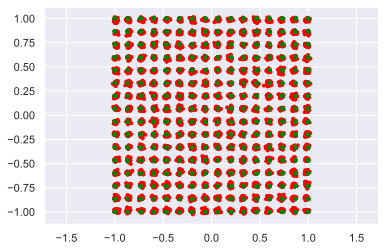

In [196]:
plot(sa_QAM_basic.xI,sa_QAM_basic.xQ,'r.')
axis('equal')
plot(sa_QAM_basic.xI_ref,sa_QAM_basic.xQ_ref,'g.')

In [22]:
EbN0 = arange(10,25,.1)
BEP_hat = sa_QAM_basic.sa_BEP(EbN0)
BEP_thy = dc.QAM_BEP_thy(EbN0,M,True)
figure(figsize=(5,5))
semilogy(EbN0,BEP_thy,label=r'Ideal')
semilogy(EbN0,BEP_hat,label=r'Mismatched')
ylim([1e-7,1e-1])
title(r'%dQAM: $\alpha_{tx} =$ %1.2f, $\alpha_{rx} =$ %1.2f, $M_{span} =$ %d' \
      % (M,alpha_tx,alpha_rx, M_span))
xlabel(r'$E_b/N_0$ (dB)')
ylabel(r'Probability of Error')
# legend = legend((r'Ideal',r'Mismatched'))
legend_obj = legend()
frame = legend_obj.get_frame()
frame.set_facecolor('white')
#grid();
tight_layout()
# savefig('BEP_16QAM_25to25_5d_plt.pdf')

NameError: name 'sa_QAM_basic' is not defined

In [20]:
M = 256
M_span = 6
alpha_tx = 0.35
alpha_rx = 0.25
# Consistently test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,30]);
for k, deg_dBk in enumerate(deg_dB):
    print('{:1.2e}'.format(deg_dBk))

TypeError: object of type 'NoneType' has no len()

In [8]:
M = 256
M_span = 6
alpha_tx = 0.35
alpha_rx = 0.25
# Consistently test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
# BEP_hat_ref1 = sa_QAM_basic_ref1.sa_BEP(EbN0)
# BEP_hat_ref2 = sa_QAM_basic_ref2.sa_BEP(EbN0)
BEP_hat = sa_QAM_basic.sa_BEP(EbN0)
BEP_thy = dc.QAM_BEP_thy(EbN0,M,True)
for BEP_t in BEP_thres:
    # Find Mismatch EbNo crossing (with mismatch)
    idx_above = nonzero(ravel(BEP_hat > BEP_t))[0]
    if len(idx_above) < 2:
        raise Exception('Decrease lower end of EbN0 range below {:1.2f}'.format(EbN0[0]))
    idx_below = nonzero(ravel(BEP_hat < BEP_t))[0]
    if len(idx_below) < 2:
        raise Exception('Increase upper end of EbN0 range above {:1.2f}'.format(EbN0[-1]))
    p3 =  polyfit(log10(BEP_hat[hstack((idx_above[-2:],idx_below[0:2]))]),
                  EbN0[hstack((idx_above[-2:],idx_below[0:2]))],3)
    EbN0_mis = polyval(p3,log10(BEP_t))
    # Find Theory EbNo crossing (ideal)
    idx_above = nonzero(ravel(BEP_thy > BEP_t))[0]
    idx_below = nonzero(ravel(BEP_thy < BEP_t))[0]
    p3_thy =  polyfit(log10(BEP_thy[hstack((idx_above[-2:],idx_below[0:2]))]),
                  EbN0[hstack((idx_above[-2:],idx_below[0:2] ))],3)
    EbN0_thy = polyval(p3_thy,log10(BEP_t))
    print('BEP_threshold = {:1.2e}, Degradation = {:1.4f} dB'.format(BEP_t,EbN0_mis - EbN0_thy))
#     print(EbN0_thy,EbN0_mis)

BEP_threshold = 1.00e-05, Degradation = 0.5382 dB
BEP_threshold = 1.00e-06, Degradation = 0.6857 dB
BEP_threshold = 1.00e-07, Degradation = 0.8336 dB
BEP_threshold = 1.00e-08, Degradation = 0.9808 dB
BEP_threshold = 1.00e-09, Degradation = 1.1268 dB


In [85]:
sa_QAM_basic.degradation(1e-5)

BEP Threshold crossings: MF mismatch 17.811 dB, Ideal 17.787 dB


0.023644036447997507

In [86]:
sa_QAM_basic_ref.degradation(1e-5)

BEP Threshold crossings: MF mismatch 17.771 dB, Ideal 17.787 dB


-0.01596343542094658

#### With Equalization

In [310]:
M = 16
sa_QAM = QAM_sa_BEP(M,0.25,0.5,N_symb=2000,M_span=6)

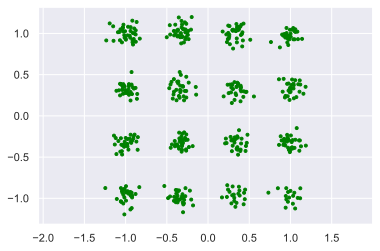

In [311]:
EbNo_operate = 14
N_taps = 21
sa_QAM.MMSE_DFE(N_taps,EbNo_operate,mu=0.001)
N_dis = 500
plot(real(sa_QAM.z_eq[-N_dis:]),imag(sa_QAM.z_eq[-N_dis:]),'g.')
axis('equal');
# dc.eye_plot(real(z_eq),2,700)
# dc.eye_plot(sa_QAM.xI,2,10*(6+6))
#grid()

In [ ]:
# stem(abs(sa_MPSK.Aopt_eq),use_line_collection=True)
fig = pltly.plotly_stem(arange(0,21),real(sa_QAM.Aopt_eq),
                        r'Index n',r'Re()',r'Equalizer Real Part',
                        stem_width=0.5, width=650);
np.sum(abs(sa_QAM.Aopt_eq))
# 10*log10(sum(abs(sa_QAM.Aopt_eq)**2))

In [ ]:
plot(abs(sa_QAM.e_eq)**2);
title(r'Equalizier Adaptation')
ylabel(r'MSE')
xlabel(r'Symbol Index')

In [ ]:
plot(sa_QAM.z.real,sa_QAM.z.imag,'.')
plot(sa_QAM.z_eq_nn.real,sa_QAM.z_eq_nn.imag,'r.')
axis('equal');
title(r'MF Alone and MF with Equalizer Predetection')
ylabel(r'Quadrature')
xlabel(r'Inphase')
legend((r'MF Alone',r'MF-EQ {} taps'.format(N_taps)),
       facecolor='white',labelspacing=0.02);

In [ ]:
EbN0 = arange(5,18,.01)
BEP_thy = dc.QAM_BEP_thy(EbN0,M,True)
BEP_hat = sa_QAM.sa_BEP(EbN0)
BEP_hat_eq = sa_QAM.sa_eq_BEP(EbN0)
pltly.BEP_plot2(EbN0,BEP_thy,BEP_hat,BEP_hat_eq, 
                r'32-PSK: alpha_tx = 0.25, alpha_rx = 0.35');

In [ ]:
fig.write_image('BEP_32PSK_25to35.pdf')

In [ ]:
figure(figsize=(5,5))
semilogy(EbN0,BEP_thy,label=r'Ideal')
semilogy(EbN0,BEP_hat,label=r'Mismatched')
semilogy(EbN0,BEP_hat_eq,label=r'Mismatched')
ylim([1e-7,1e-1])
title(r'16QAM: $\alpha_{tx} = 0.25$, $\alpha_{rx} = 0.5$')
xlabel(r'$E_b/N_0$ (dB)')
ylabel(r'Probability of Error')
legend((r'Ideal',r'Mismatched No EQ',r'Mismatched EQ {} tap'.format(N_taps)),
         facecolor='white',labelspacing=0.02);
#grid();
xlim([12,15])
ylim([1e-6,2e-4])
tight_layout()
savefig('BEP_16QAM_25to5_eq21.pdf')

In [ ]:
BEP_thesh = 1e-6
D_dB_noeq = sa_QAM.degradation(BEP_thesh,False,[9,15])
print('Degradation noeq at {} is {:6.3f} dB'.format(BEP_thesh,D_dB_noeq))
D_dB_eq = sa_QAM.degradation(BEP_thesh,True,[9,15])
print('Degradation eq at {} is {:6.3f} dB'.format(BEP_thesh,D_dB_eq))

---

## Data Table Collection

### MPSK

#### RST Table

#### $\alpha$ Tx/Rx = 0.25/0.3

In [144]:
M = 4
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.3
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
0\*
0\*
0\*
0\*


In [145]:
M = 8
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.3
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
0\*
0\*
0\*
0\*


In [146]:
M = 16
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.3
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,30]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
0\*
1.13e-02
1.36e-02
1.58e-02


In [147]:
M = 32
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.3
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,30]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

2.89e-02
3.72e-02
4.56e-02
5.40e-02
6.24e-02


#### $\alpha$ Tx/Rx = 0.25/0.35

In [148]:
M = 4
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.35
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
0\*
0\*
0\*
0\*


In [149]:
M = 8
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.35
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
1.22e-02
1.49e-02
1.77e-02
2.06e-02


In [150]:
M = 16
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.35
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,30]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

3.87e-02
4.92e-02
5.97e-02
7.03e-02
8.09e-02


In [151]:
M = 32
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.35
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,30]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

1.46e-01
1.86e-01
2.26e-01
2.67e-01
3.07e-01


#### $\alpha$ Tx/Rx = 0.25/0.4

In [152]:
M = 4
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.4
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

1.00e-02
1.26e-02
1.53e-02
1.80e-02
2.06e-02


In [153]:
M = 8
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.4
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

3.47e-02
4.39e-02
5.31e-02
6.23e-02
7.16e-02


In [154]:
M = 16
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.4
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,30]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

1.32e-01
1.67e-01
2.02e-01
2.36e-01
2.71e-01


In [155]:
M = 32
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.4
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,30]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

5.06e-01
6.43e-01
7.80e-01
9.14e-01
1.04e+00


#### $\alpha$ Tx/Rx = 0.25/0.45

In [156]:
M = 4
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.45
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

2.41e-02
3.01e-02
3.62e-02
4.23e-02
4.84e-02


In [157]:
M = 8
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.45
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

8.15e-02
1.02e-01
1.24e-01
1.45e-01
1.65e-01


In [158]:
M = 16
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.45
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,30]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

3.06e-01
3.86e-01
4.64e-01
5.42e-01
6.18e-01


In [159]:
M = 32
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.45
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,30]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

1.22e+00
1.55e+00
1.87e+00
2.18e+00
2.46e+00


#### $\alpha$ Tx/Rx = 0.25/0.5

In [160]:
M = 4
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.5
# Test with the same bit sequence
data = int64(dc.m_seq(16))
# data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

4.37e-02
5.46e-02
6.56e-02
7.66e-02
8.77e-02


In [161]:
M = 8
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.5
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

1.49e-01
1.87e-01
2.25e-01
2.62e-01
3.00e-01


In [162]:
M = 16
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.5
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,30]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

5.61e-01
7.05e-01
8.46e-01
9.83e-01
1.11e+00


In [163]:
M = 32
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.5
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

2.38e+00
3.04e+00
3.65e+00
4.17e+00
4.61e+00


#### $\alpha$ Tx/Rx = 0.3/0.25

In [164]:
M = 4
M_span = 8
alpha_tx = 0.3
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
# data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
0\*
0\*
0\*
0\*


In [165]:
M = 8
M_span = 8
alpha_tx = 0.3
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
0\*
0\*
0\*
0\*


In [166]:
M = 16
M_span = 8
alpha_tx = 0.3
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,30]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
0\*
1.14e-02
1.36e-02
1.58e-02


In [167]:
M = 32
M_span = 8
alpha_tx = 0.3
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

2.90e-02
3.73e-02
4.56e-02
5.40e-02
6.25e-02


#### $\alpha$ Tx/Rx = 0.35/0.25

In [168]:
M = 4
M_span = 8
alpha_tx = 0.35
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
0\*
0\*
0\*
0\*


In [169]:
M = 8
M_span = 8
alpha_tx = 0.35
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
1.21e-02
1.49e-02
1.77e-02
2.05e-02


In [170]:
M = 16
M_span = 8
alpha_tx = 0.35
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,30]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

3.88e-02
4.92e-02
5.98e-02
7.04e-02
8.10e-02


In [171]:
M = 32
M_span = 8
alpha_tx = 0.35
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

1.46e-01
1.86e-01
2.26e-01
2.67e-01
3.07e-01


#### $\alpha$ Tx/Rx = 0.4/0.25

In [172]:
M = 4
M_span = 8
alpha_tx = 0.4
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
1.26e-02
1.53e-02
1.80e-02
2.06e-02


In [173]:
M = 8
M_span = 8
alpha_tx = 0.4
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

3.48e-02
4.39e-02
5.31e-02
6.24e-02
7.16e-02


In [174]:
M = 16
M_span = 8
alpha_tx = 0.4
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,30]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

1.32e-01
1.67e-01
2.02e-01
2.36e-01
2.71e-01


In [175]:
M = 32
M_span = 8
alpha_tx = 0.4
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

5.06e-01
6.43e-01
7.80e-01
9.14e-01
1.04e+00


#### $\alpha$ Tx/Rx = 0.45/0.25

In [176]:
M = 4
M_span = 8
alpha_tx = 0.45
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

2.40e-02
3.01e-02
3.61e-02
4.22e-02
4.84e-02


In [177]:
M = 8
M_span = 8
alpha_tx = 0.45
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

8.16e-02
1.03e-01
1.24e-01
1.45e-01
1.66e-01


In [178]:
M = 16
M_span = 8
alpha_tx = 0.45
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,30]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

3.06e-01
3.86e-01
4.64e-01
5.42e-01
6.18e-01


In [179]:
M = 32
M_span = 8
alpha_tx = 0.45
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

1.22e+00
1.55e+00
1.87e+00
2.18e+00
2.46e+00


#### $\alpha$ Tx/Rx = 0.5/0.25

In [180]:
M = 4
M_span = 8
alpha_tx = 0.5
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

4.43e-02
5.52e-02
6.62e-02
7.72e-02
8.83e-02


In [181]:
M = 8
M_span = 8
alpha_tx = 0.5
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[5,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

1.49e-01
1.87e-01
2.25e-01
2.62e-01
2.99e-01


In [250]:
M = 16
M_span = 8
alpha_tx = 0.5
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,30]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

5.61e-01
7.05e-01
8.46e-01
9.83e-01
1.11e+00


In [249]:
M = 32
M_span = 8
alpha_tx = 0.5
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_MPSK_basic = MPSK_sa_BEP(M,alpha_tx,alpha_rx,N_symb=None,
                            M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
deg_dB = sa_MPSK_basic.deg_polyfit(BEP_thres,search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

2.38e+00
3.04e+00
3.65e+00
4.17e+00
4.61e+00


### MQAM

#### RST Table

#### $\alpha$ Tx/Rx = 0.25/0.3

In [229]:
M = 4
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.3
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
0\*
0\*
0\*
0\*


In [230]:
M = 16
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.3
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
0\*
0\*
0\*
0\*


In [231]:
M = 64
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.3
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

3.80e-02
4.17e-02
4.53e-02
4.89e-02
5.25e-02


In [232]:
M = 256
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.3
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

3.83e-02
5.23e-02
6.64e-02
8.06e-02
9.47e-02


#### $\alpha$ Tx/Rx = 0.25/0.35

In [233]:
M = 4
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.35
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
0\*
0\*
0\*
0\*


In [234]:
M = 16
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.35
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

1.17e-02
1.56e-02
1.95e-02
2.35e-02
2.74e-02


In [235]:
M = 64
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.35
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

8.87e-02
1.05e-01
1.22e-01
1.39e-01
1.56e-01


In [236]:
M = 256
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.35
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

2.44e-01
3.13e-01
3.83e-01
4.52e-01
5.22e-01


#### $\alpha$ Tx/Rx = 0.25/0.4

In [237]:
M = 4
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.4
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
1.26e-02
1.53e-02
1.79e-02
2.06e-02


In [238]:
M = 16
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.4
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

4.79e-02
6.08e-02
7.37e-02
8.67e-02
9.97e-02


In [239]:
M = 64
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.4
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

2.40e-01
2.96e-01
3.51e-01
4.07e-01
4.61e-01


In [240]:
M = 256
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.4
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

8.86e-01
1.13e+00
1.39e+00
1.64e+00
1.89e+00


#### $\alpha$ Tx/Rx = 0.25/0.45

In [241]:
M = 4
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.45
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

2.40e-02
3.00e-02
3.61e-02
4.21e-02
4.81e-02


In [242]:
M = 16
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.45
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

1.15e-01
1.44e-01
1.74e-01
2.03e-01
2.33e-01


In [243]:
M = 64
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.45
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

5.29e-01
6.60e-01
7.89e-01
9.16e-01
1.04e+00


In [244]:
M = 256
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.45
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

2.27e+00
2.98e+00
3.72e+00
4.48e+00
5.18e+00


#### $\alpha$ Tx/Rx = 0.25/0.5

In [245]:
M = 4
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.5
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

4.42e-02
5.50e-02
6.59e-02
7.67e-02
8.75e-02


In [246]:
M = 16
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.5
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

2.11e-01
2.65e-01
3.18e-01
3.71e-01
4.23e-01


In [247]:
M = 64
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.5
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

9.67e-01
1.21e+00
1.46e+00
1.69e+00
1.92e+00


In [248]:
M = 256
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.5
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,40]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

5.06e+00
7.24e+00
9.92e+00
1.17e+01
1.28e+01


#### $\alpha$ Tx/Rx = 0.3/0.25

In [205]:
M = 4
M_span = 8
alpha_tx = 0.3
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
0\*
0\*
0\*
0\*


In [206]:
M = 16
M_span = 8
alpha_tx = 0.3
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
0\*
0\*
0\*
0\*


In [207]:
M = 64
M_span = 8
alpha_tx = 0.3
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

3.80e-02
4.16e-02
4.53e-02
4.89e-02
5.25e-02


In [251]:
M = 256
M_span = 8
alpha_tx = 0.3
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,40]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

3.85e-02
5.25e-02
6.66e-02
8.08e-02
9.50e-02


#### $\alpha$ Tx/Rx = 0.35/0.25

In [208]:
M = 4
M_span = 8
alpha_tx = 0.35
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
0\*
0\*
0\*
0\*


In [209]:
M = 16
M_span = 8
alpha_tx = 0.35
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

1.17e-02
1.56e-02
1.95e-02
2.35e-02
2.74e-02


In [210]:
M = 64
M_span = 8
alpha_tx = 0.35
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

8.87e-02
1.05e-01
1.22e-01
1.39e-01
1.56e-01


In [211]:
M = 256
M_span = 8
alpha_tx = 0.35
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,40]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

2.44e-01
3.13e-01
3.83e-01
4.53e-01
5.22e-01


#### $\alpha$ Tx/Rx = 0.4/0.25

In [212]:
M = 4
M_span = 8
alpha_tx = 0.4
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
1.26e-02
1.53e-02
1.79e-02
2.06e-02


In [216]:
M = 16
M_span = 8
alpha_tx = 0.4
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

4.79e-02
6.08e-02
7.37e-02
8.67e-02
9.97e-02


In [217]:
M = 64
M_span = 8
alpha_tx = 0.4
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

2.40e-01
2.96e-01
3.51e-01
4.07e-01
4.61e-01


In [218]:
M = 256
M_span = 8
alpha_tx = 0.4
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,40]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

8.86e-01
1.14e+00
1.39e+00
1.64e+00
1.89e+00


#### $\alpha$ Tx/Rx = 0.45/0.25

In [219]:
M = 4
M_span = 8
alpha_tx = 0.45
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

2.40e-02
3.00e-02
3.60e-02
4.21e-02
4.81e-02


In [220]:
M = 16
M_span = 8
alpha_tx = 0.45
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

1.15e-01
1.44e-01
1.74e-01
2.03e-01
2.33e-01


In [221]:
M = 64
M_span = 8
alpha_tx = 0.45
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

5.29e-01
6.60e-01
7.89e-01
9.16e-01
1.04e+00


In [224]:
M = 256
M_span = 8
alpha_tx = 0.45
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,40]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

2.27e+00
2.98e+00
3.72e+00
4.48e+00
5.18e+00


#### $\alpha$ Tx/Rx = 0.5/0.25

In [225]:
M = 4
M_span = 8
alpha_tx = 0.5
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

4.42e-02
5.50e-02
6.59e-02
7.67e-02
8.75e-02


In [226]:
M = 16
M_span = 8
alpha_tx = 0.5
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[3,20]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

2.11e-01
2.65e-01
3.18e-01
3.71e-01
4.23e-01


In [227]:
M = 64
M_span = 8
alpha_tx = 0.5
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,35]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

9.67e-01
1.21e+00
1.46e+00
1.69e+00
1.92e+00


In [284]:
M = 16
M_span = 8
alpha_tx = 0.25
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_basic = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_basic.deg_polyfit(BEP_thres, EQ=False, search_int=[10,40]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

0\*
0\*
0\*
0\*
0\*


In [257]:
import sk_dsp_comm.fir_design_helper as fir_h

In [264]:
sum(sa_QAM_256p5p25.b_r)

1.0001777375084506

In [265]:
sum(sa_QAM_basic.b_r)

0.9999926499488265

In [271]:
f = arange(0,0.5,1/4096)
w, H1 = signal.freqz(sa_QAM_basic.b_r,1,2*pi*f)
w, H2 = signal.freqz(sa_QAM_256p5p25.b_r,1,2*pi*f)

In [273]:
sum(abs(H1)**2)/4096

0.05012127319194877

In [274]:
sum(abs(H2)**2)/4096

0.05011896191122379

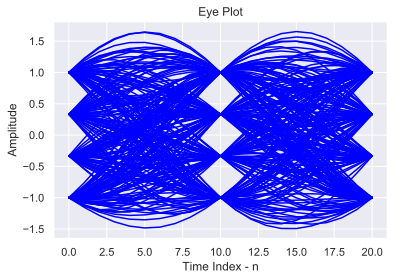

In [285]:
dc.eye_plot(sa_QAM_basic.z_MFMM[:5000].real,20,10*16)
grid();

In [252]:
M = 256
M_span = 8
alpha_tx = 0.5
alpha_rx = 0.25
# Test with the same bit sequence
data = int64(dc.m_seq(16))
data = hstack((data, data))
sa_QAM_256p5p25 = QAM_sa_BEP(M,alpha_tx,alpha_rx,
                          N_symb=None,M_span=M_span,ext_data=data)
BEP_thres = [1e-5,1e-6,1e-7,1e-8,1e-9]
EbN0 = arange(20,40,.05) # arange(3,18,.01)
deg_dB = sa_QAM_256p5p25









.deg_polyfit(BEP_thres, EQ=False, search_int=[10,40]);
for k, deg_dBk in enumerate(deg_dB):
    if deg_dBk < 0.01:
        print('0\*')
    else:
        print('{:1.2e}'.format(deg_dBk))

5.06e+00
7.24e+00
9.92e+00
1.17e+01
1.28e+01


## Special Plots

### MPSK Degradation at 1E-6 Comparing Mismatch Ratio and Inverted Mismatch Ratio vs $M$

In [ ]:
deg_dB_p5_to_p25 = [ , , , 1.21,3.04]
deg_dB_p25_to_p5 = []

### MQAM Degradation at 1E-6 Comparing Mismatch Ratios Noninverted & Inverted vs $M$

In [ ]:
# M = 4, 16, 64, 256
deg_dB_p5_to_p25 = [5.52e-02, 1.87e-01, 7.05e-01, 3.04e+00]
deg_dB_p25_to_p5 = [5.46e-02, 1.87e-01, 7.05e-01, 7.24e+00]